# Preliminary Steps

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
# import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
nltk.download('stopwords')
import string
# from torchtext.data.utils import get_tokenizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


In [3]:
df = pd.read_csv('fake_job_postings.csv')
df.head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


In [4]:
df['salary_range'].isna().sum()/len(df['salary_range'])

0.8395973154362416

# Data Cleaning

In [5]:
def preprocessor(sentences):

    # Necessary steps - calls specific items used for preprocessing functions
    processed_sentences = []
    translator = str.maketrans('', '', string.punctuation)
    # tokenizer = get_tokenizer("basic_english")
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    # Preprocessing steps (non-essential steps can be removed)
    for sentence in sentences:

        # Turns all words lowercase
        sentence = sentence.lower()

        # Removes punctuation
        pl_sentence = sentence.translate(translator)

        # Tokenizes sentence
        tokens = word_tokenize(pl_sentence)

        # Removes stopwords
        sw_tokens = [token for token in tokens if token not in stop_words]

        # # Stems words
        st_tokens = [stemmer.stem(token) for token in sw_tokens]

        # # Removes uncommon words
        # freq_dist = FreqDist(tokens)
        # threshold = 1
        # fq_tokens = [token for token in tokens if freq_dist[token] > threshold]

        processed_sentences.append(" ".join(st_tokens))
    return processed_sentences

In [6]:
# Remove duplicates
df = df.drop_duplicates()

# # Get salary data: range (distance between proposed salaries) and average (mean of proposed salaries)
# salary = []
# for item in df['salary_range']:
#     try:
#         x = item.split("-")
#         x[0] = int(x[0])
#         x[1] = int(x[1])
#         salary.append(x)
#     except:
#         salary.append([np.nan, np.nan])
# # Range variable
# salary_rng = []
# # Average variable
# salary_avg = []
# for item in salary:
#     try:
#         salary_rng.append(abs(item[0]-item[1]))
#         salary_avg.append((item[0]+item[1])/2)
#     except:
#         salary_rng.append(np.nan)
#         salary_avg.append(np.nan)
# df['salary_rng'] = salary_rng
# df['salary_avg'] = salary_avg

# Get country variable: country denoted in job posting:
countries = []
for item in df['location']:
    try:
        countries.append(item.split(",")[0])
    except:
        countries.append(np.nan)
df['country'] = countries

# Clean text data
text_features = ['title', 'description', 'company_profile', 'requirements', 'benefits']
for item in text_features:
    df[item] = df[item].fillna('')
    df[item] = preprocessor(df[item])

# Clean categorical data
categorical_features = ['country', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']
for item in categorical_features:
    df[item] = df[item].fillna('Unknown')
    df[item] = [entry.lower() for entry in df[item]]

In [7]:
# Drop unnecessary columns
drop_columns = ['job_id', 'salary_range', 'location', 'department']
df_sep = df.drop(columns=drop_columns)

print(df_sep.shape)
df_sep.head()


(17880, 15)


,title,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country
0,market intern,food52 weve creat groundbreak awardwin cook si...,food52 fastgrow jame beard awardwin onlin food...,experi content manag system major plu blog cou...,,0,1,0,other,internship,unknown,unknown,marketing,0,us
1,custom servic cloud video product,90 second world cloud video product service90 ...,organis focus vibrant awesomedo passion custom...,expect youyour key respons commun client 90 se...,get usthrough part 90 second team gainexperi w...,0,1,0,full-time,not applicable,unknown,marketing and advertising,customer service,0,nz
2,commiss machineri assist cma,valor servic provid workforc solut meet need c...,client locat houston activ seek experienc comm...,implement precommiss commiss procedur rotari e...,,0,1,0,unknown,unknown,unknown,unknown,unknown,0,us
3,account execut washington dc,passion improv qualiti life geographi heart ev...,compani esri – environment system research ins...,educ bachelor ’ master ’ gi busi administr rel...,cultur anyth corporate—w collabor creativ envi...,0,1,0,full-time,mid-senior level,bachelor's degree,computer software,sales,0,us
4,bill review manag,spotsourc solut llc global human capit manag c...,job titl item review managerloc fort worth tx ...,qualificationsrn licens state texasdiploma bac...,full benefit offer,0,1,1,full-time,mid-senior level,bachelor's degree,hospital & health care,health care provider,0,us


In [8]:
df['text_features'] = df['title'] + df['company_profile'] + df['description'] + df['requirements'] + df['benefits']

drop_columns = ['job_id', 'salary_range', 'location', 'department', 'title', 'company_profile', 'description', 'requirements', 'benefits']
df_concat = df.drop(columns=drop_columns)

categorical_features = ['country', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']

print(df_concat.shape)
df_concat.head()

(17880, 11)


,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,text_features
0,0,1,0,other,internship,unknown,unknown,marketing,0,us,market internfood52 weve creat groundbreak awa...
1,0,1,0,full-time,not applicable,unknown,marketing and advertising,customer service,0,nz,custom servic cloud video product90 second wor...
2,0,1,0,unknown,unknown,unknown,unknown,unknown,0,us,commiss machineri assist cmavalor servic provi...
3,0,1,0,full-time,mid-senior level,bachelor's degree,computer software,sales,0,us,account execut washington dcpassion improv qua...
4,0,1,1,full-time,mid-senior level,bachelor's degree,hospital & health care,health care provider,0,us,bill review managspotsourc solut llc global hu...


# Training (Separate Approach)

In [9]:
# Features and target
X = df_sep.drop('fraudulent', axis=1)
y = df_sep['fraudulent']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)


Training set: (14304, 14)
Testing set: (3576, 14)


In [10]:
import math

# max_feats = []
# for i in range(1, 13):
#     max_feats.append(int(math.exp(i)/5))

# max_feats[0] = 1

# max_feats

max_feats = [13]

[1, 1, 4, 10, 29, 80, 219, 596, 1620, 4405, 11974, 32550]

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import numpy as np

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

train_f1s = []
test_f1s = []

for item in max_feats:
    print(f"Running for {item} features...")

    # Store F1s per fold
    train_fold_scores = []
    test_fold_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # TF-IDF
        text_transformer = TfidfVectorizer(max_features=item, ngram_range=(1,2), min_df=5, sublinear_tf=True)
        categorical_transformer = OneHotEncoder(handle_unknown='ignore')

        preprocessor = ColumnTransformer(
        transformers=[
            ('title_tfidf', text_transformer, 'title'),
            ('desc_tfidf', text_transformer, 'description'),
            ('profile_tfidf', text_transformer, 'company_profile'),
            ('requirements_tfidf', text_transformer, 'requirements'),
            ('benefits_tfidf', text_transformer, 'benefits'),
            ('cat', categorical_transformer, categorical_features),
            ('num', 'passthrough', ['telecommuting', 'has_company_logo', 'has_questions'])
        ],
        remainder='drop'
        )

        svm_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('scaler', StandardScaler(with_mean=False)),
            ('classifier', SVC(kernel='linear', C=0.01, class_weight='balanced',
                               probability=True, random_state=1))
        ])

        # Fit
        svm_pipeline.fit(X_tr, y_tr)

        # Predict on training fold
        y_prob_train = svm_pipeline.predict_proba(X_tr)[:, 1]
        p, r, _ = precision_recall_curve(y_tr, y_prob_train)
        f1_train = 2 * (p * r) / (p + r + 1e-6)
        train_fold_scores.append(f1_train.max())

        # Predict on validation fold
        y_prob_val = svm_pipeline.predict_proba(X_val)[:, 1]
        p, r, _ = precision_recall_curve(y_val, y_prob_val)
        f1_val = 2 * (p * r) / (p + r + 1e-6)
        test_fold_scores.append(f1_val.max())

    # Store average F1 across folds
    train_f1s.append((np.mean(train_fold_scores), np.std(train_fold_scores)))
    test_f1s.append((np.mean(test_fold_scores), np.std(test_fold_scores)))

    print(f"Feature cap {item} done. Train F1: {train_f1s[-1][0]:.4f}, Test F1: {test_f1s[-1][0]:.4f}")

Running for 1 features...
Feature cap 1 done. Train F1: 0.5457, Test F1: 0.4932
Running for 1 features...
Feature cap 1 done. Train F1: 0.5457, Test F1: 0.4932
Running for 4 features...
Feature cap 4 done. Train F1: 0.5839, Test F1: 0.5217
Running for 10 features...
Feature cap 10 done. Train F1: 0.6094, Test F1: 0.5252
Running for 29 features...
Feature cap 29 done. Train F1: 0.7222, Test F1: 0.5967
Running for 80 features...
Feature cap 80 done. Train F1: 0.8999, Test F1: 0.6840
Running for 219 features...
Feature cap 219 done. Train F1: 0.9918, Test F1: 0.7490
Running for 596 features...
Feature cap 596 done. Train F1: 1.0000, Test F1: 0.7836
Running for 1620 features...
Feature cap 1620 done. Train F1: 1.0000, Test F1: 0.8305
Running for 4405 features...
Feature cap 4405 done. Train F1: 1.0000, Test F1: 0.8323
Running for 11974 features...
Feature cap 11974 done. Train F1: 1.0000, Test F1: 0.8467
Running for 32550 features...
Feature cap 32550 done. Train F1: 1.0000, Test F1: 0.853

In [20]:
from scipy import stats

mean1, std1, n1 = 0.8530183552307035, 0.024837403069600538, len(df['text_features'])/5
mean2, std2, n2 = 0.8632746656330342, 0.021571951613661697, len(df['text_features'])/5
t_stat, p_value = stats.ttest_ind_from_stats(mean2, std2, n2, mean1, std1, n1)

print(t_stat)
print(p_value)

18.643479913084843
8.744559641311169e-76


In [17]:
len(df['text_features'])/5

3576.0

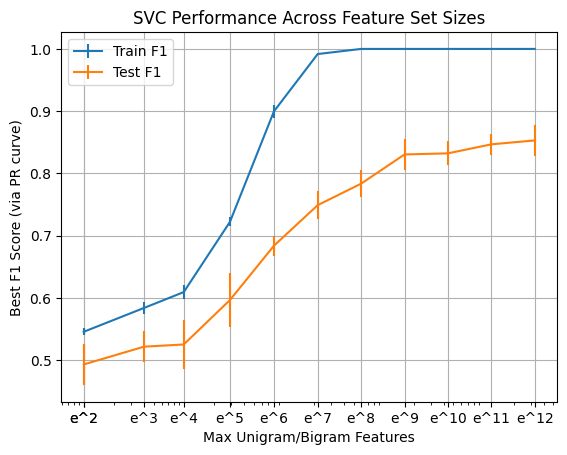

In [13]:
import matplotlib.pyplot as plt

x = max_feats
train_means, train_stds = zip(*train_f1s)
test_means, test_stds = zip(*test_f1s)

plt.errorbar(x, train_means, yerr=train_stds, label='Train F1')
plt.errorbar(x, test_means, yerr=test_stds, label='Test F1')
plt.xscale('log')
plt.xlabel('Max Unigram/Bigram Features')
plt.ylabel('Best F1 Score (via PR curve)')
max_labels = []
for i in range(1, 13):
    max_labels.append("e^" + f"{i}")
plt.xticks(max_feats, 
           max_labels)
plt.legend()
plt.title('SVC Performance Across Feature Set Sizes')
plt.grid(True)
plt.show()

In [14]:
print(train_f1s)


[(0.5456851588097522, 0.0059065380672717405), (0.5456851588097522, 0.0059065380672717405), (0.5838976265188807, 0.010121036323903142), (0.6093971558627345, 0.011321776424860258), (0.722207824872432, 0.007090223253892453), (0.8998511743741929, 0.010284290807149443), (0.9917736878387691, 0.0016259518220683342), (0.99999950000025, 0.0), (0.99999950000025, 0.0), (0.99999950000025, 0.0), (0.99999950000025, 0.0), (0.99999950000025, 0.0)]


In [15]:
print(test_f1s)

[(0.49316894990544735, 0.032902251688802536), (0.49316894990544735, 0.032902251688802536), (0.5216967717076497, 0.0253281332062429), (0.5252499866940233, 0.039515229022283375), (0.5966531336548382, 0.04370990132152579), (0.6839660124932931, 0.01611264992543568), (0.7490129963994432, 0.02259121243800165), (0.7835839333205262, 0.021709438989015162), (0.830497070829556, 0.025145254291867678), (0.8322619696708429, 0.019309082087046108), (0.8467454358473117, 0.017374684234766034), (0.8530183552307035, 0.024837403069600538)]


In [ ]:
# TF-IDF for text
text_transformer = TfidfVectorizer(max_features=6000, ngram_range=(1,2), min_df=5, sublinear_tf=True)

# Categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine
preprocessor = ColumnTransformer(
    transformers=[
        ('title_tfidf', text_transformer, 'title'),
        ('desc_tfidf', text_transformer, 'description'),
        ('profile_tfidf', text_transformer, 'company_profile'),
        ('requirements_tfidf', text_transformer, 'requirements'),
        ('benefits_tfidf', text_transformer, 'benefits'),
        ('cat', categorical_transformer, categorical_features),
        ('num', 'passthrough', ['telecommuting', 'has_company_logo', 'has_questions'])
    ],
    remainder='drop'
)

In [ ]:
# Define SVM pipeline
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),  # with_mean=False because of sparse TF-IDF
    ('classifier', SVC(kernel='linear', C=3.0, class_weight='balanced', probability=True, random_state=1))
])

# Fit
param_grid = {
    # 'classifier__C': [0.01, 0.1, 1]
    'classifier__C': [0.01]
}

grid_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1',  # Optimize for F1-score
    n_jobs=-1,  # Use all available CPU cores
    verbose=2  # Print progress
)

grid_search.fit(X_train, y_train)

print("Best C:", grid_search.best_params_['classifier__C'])
print("Best cross-validated F1-score:", grid_search.best_score_)

best_model_S = grid_search.best_estimator_

y_pred = best_model_S.predict(X_test)
y_prob = best_model_S.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Separate Confusion Matrix after C Tuning')
# plt.show()

# roc_auc = roc_auc_score(y_test, y_prob)
# print(f"ROC AUC Score: {roc_auc:.4f}") 

# # # Predict
# # y_pred = svm_pipeline.predict(X_test)
# # y_prob = svm_pipeline.predict_proba(X_test)[:,1]  # Probability scores for AUC


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best C: 0.01
Best cross-validated F1-score: 0.817793919701295
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.95      0.80      0.87       173

    accuracy                           0.99      3576
   macro avg       0.97      0.90      0.93      3576
weighted avg       0.99      0.99      0.99      3576



In [ ]:
# # Classification report
# print(classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # ROC AUC Score
# roc_auc = roc_auc_score(y_test, y_prob)
# print(f"ROC AUC Score: {roc_auc:.4f}")


In [ ]:
# Calculate precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
print(f"Number of thresholds: {len(thresholds)}")

# F1 scores
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)

# Best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1-Score: {best_f1:.4f}")

Number of thresholds: 3363
Best Threshold: 0.2449
Best F1-Score: 0.8908


In [ ]:
# Apply best threshold
y_pred_threshold = (y_prob >= best_threshold).astype(int)

# Classification report
print(classification_report(y_test, y_pred_threshold))

# # Confusion Matrix (Threshold Tuned)
# cm_thresh = confusion_matrix(y_test, y_pred_threshold)
# sns.heatmap(cm_thresh, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Separate Confusion Matrix after Threshold Tuning')
# plt.show()

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.89      0.90      0.89       173

    accuracy                           0.99      3576
   macro avg       0.94      0.95      0.94      3576
weighted avg       0.99      0.99      0.99      3576



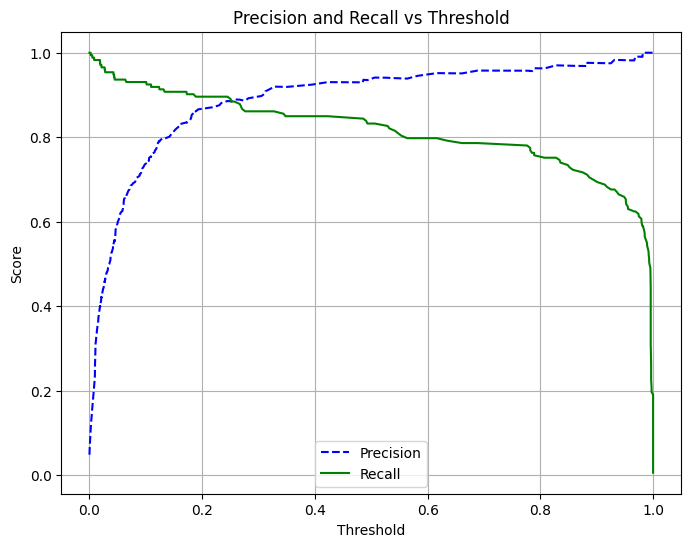

In [ ]:
# Plot precision and recall vs threshold
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()

# Training (Combined Approach)

In [ ]:
# Features and target
X = df_concat.drop('fraudulent', axis=1)
y = df_concat['fraudulent']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)

Training set: (14304, 10)
Testing set: (3576, 10)


In [ ]:
# TF-IDF for text
text_transformer2 = TfidfVectorizer(max_features=50000, ngram_range=(1,2), min_df=5, sublinear_tf=True)
categorical_transformer2 = OneHotEncoder(handle_unknown='ignore')

# Combine
preprocessor2 = ColumnTransformer(
    transformers=[
        ('desc_tfidf', text_transformer2, 'text_features'),
        ('cat', categorical_transformer2, categorical_features),
        ('num', 'passthrough', ['telecommuting', 'has_company_logo', 'has_questions'])
    ],
    remainder='drop')

In [ ]:
# Define SVM pipeline
svm_pipeline2 = Pipeline(steps=[
    ('preprocessor', preprocessor2),
    ('scaler', StandardScaler(with_mean=False)),  # with_mean=False because of sparse TF-IDF
    ('classifier', SVC(kernel='linear', C=3.0, class_weight='balanced', probability=True, random_state=1))
])

param_grid = {
    # 'classifier__C': [0.01, 0.1, 1]
    'classifier__C': [0.01]
}

grid_search = GridSearchCV(
    estimator=svm_pipeline2,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1',  # Optimize for F1-score
    n_jobs=-1,  # Use all available CPU cores
    verbose=2  # Print progress
)

grid_search.fit(X_train, y_train)

print("Best C:", grid_search.best_params_['classifier__C'])
print("Best cross-validated F1-score:", grid_search.best_score_)

best_model_C = grid_search.best_estimator_

y_pred = best_model_C.predict(X_test)
y_prob = best_model_C.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Combined Confusion Matrix after C Tuning')
# plt.show()

# roc_auc = roc_auc_score(y_test, y_prob)
# print(f"ROC AUC Score: {roc_auc:.4f}") 

# # # Fit
# # svm_pipeline2.fit(X_train, y_train)

# # # Predict
# # y_pred = svm_pipeline2.predict(X_test)
# # y_prob = svm_pipeline2.predict_proba(X_test)[:,1]  # Probability scores for AUC

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................classifier__C=0.01; total time= 2.9min
[CV] END .................................classifier__C=0.01; total time= 4.8min
[CV] END .................................classifier__C=0.01; total time= 2.8min
[CV] END .................................classifier__C=0.01; total time= 4.8min
[CV] END .................................classifier__C=0.01; total time= 2.9min
[CV] END .................................classifier__C=0.01; total time= 5.0min
[CV] END .................................classifier__C=0.01; total time= 3.0min
[CV] END .................................classifier__C=0.01; total time= 5.0min
[CV] END .................................classifier__C=0.01; total time= 3.1min
[CV] END .................................classifier__C=0.01; total time= 5.1min
Best C: 0.01
Best cross-validated F1-score: 0.8239464493605556
              precision    recall  f1-score   support

           0 

In [ ]:
# # Classification report
# print(classification_report(y_test, y_pred))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

# # ROC AUC Score
# roc_auc = roc_auc_score(y_test, y_prob)
# print(f"ROC AUC Score: {roc_auc:.4f}")

In [ ]:
# Calculate precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
print(f"Number of thresholds: {len(thresholds)}")

# F1 scores
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)

# Best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1-Score: {best_f1:.4f}")

Number of thresholds: 3359
Best Threshold: 0.3621
Best F1-Score: 0.9384


In [ ]:
# Apply best threshold
y_pred_threshold = (y_prob >= best_threshold).astype(int)

# Classification report
print(classification_report(y_test, y_pred_threshold))

# # Confusion Matrix (Threshold Tuned)
# cm_thresh = confusion_matrix(y_test, y_pred_threshold)
# sns.heatmap(cm_thresh, annot=True, fmt='d', cmap='Reds')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Combined Confusion Matrix after Threshold Tuning)')
# plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3403
           1       0.95      0.92      0.94       173

    accuracy                           0.99      3576
   macro avg       0.97      0.96      0.97      3576
weighted avg       0.99      0.99      0.99      3576



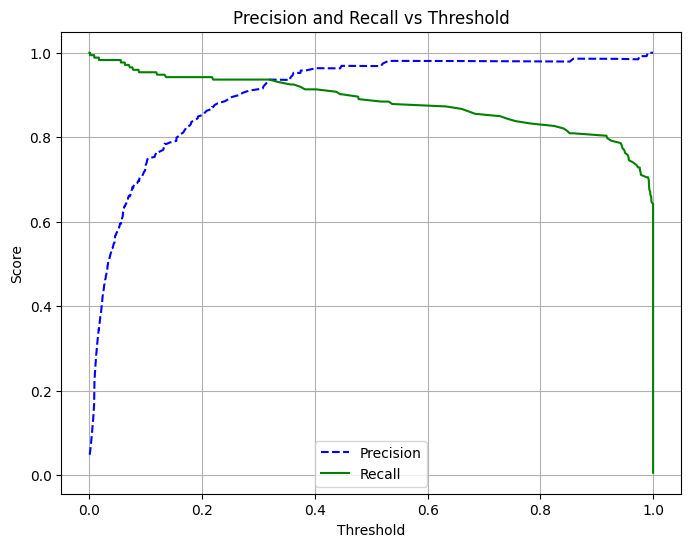

In [ ]:
# Plot precision and recall vs threshold
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()

# WordCloud Generation

In [ ]:
best_pipe = best_model_C

coefs = best_pipe.named_steps['classifier'].coef_

if hasattr(coefs, "toarray"):
    coefs = coefs.toarray()

coefs = coefs.flatten()

feature_names = best_pipe.named_steps['preprocessor'].get_feature_names_out()

importances = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(coefs)
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

print(importances)


                                       feature  importance
0                        desc_tfidf__executive    0.022596
1                               desc_tfidf__ux    0.022489
2                               desc_tfidf__de    0.019559
3                             desc_tfidf__fill    0.018559
4                        desc_tfidf__migration    0.017435
...                                        ...         ...
50282                desc_tfidf__foster thirst    0.000000
50283            desc_tfidf__innovative things    0.000000
50284                    desc_tfidf__apply hit    0.000000
50285  desc_tfidf__proceduresfollow department    0.000000
50286             desc_tfidf__ios applications    0.000000

[50287 rows x 2 columns]


In [ ]:
desc = {}

for i, row in importances.iterrows():
    if "desc_tfidf__" in row['feature']:
        desc[row['feature'].replace("desc_tfidf__", "")] = row['importance']
    else:
        pass

cloud = WordCloud(background_color="white",
    width=1000,
    height=1000,
    max_words=20,
    relative_scaling=1,
    colormap='viridis',
    normalize_plurals=False).generate_from_frequencies(desc)

plt.imshow(cloud)

KeyboardInterrupt: 

In [ ]:
# from MLstatkit.stats import Delong_test


y_test = df_sep['fraudulent']
y_probS = best_model_S.predict_proba(df_sep)[:, 1]
y_probC = best_model_C.predict_proba(df_concat)[:, 1]

In [ ]:
z_score, p_value = Delong_test(y_test, y_probC, y_probS)

print(f"z-score: {z_score}, P-Value: {p_value}")

In [ ]:
import scipy.stats as spc

In [ ]:
spc.ttest_rel(y_probC, y_probS)

TtestResult(statistic=np.float64(4.77671692025102), pvalue=np.float64(1.795936929111992e-06), df=np.int64(17879))

In [ ]:
spc.ttest_ind(y_probC, y_probS)

TtestResult(statistic=np.float64(0.8178494287972955), pvalue=np.float64(0.4134486193262772), df=np.float64(35758.0))

In [ ]:
sum(y_probC)/len(y_probC)

np.float64(0.052930549635273404)

In [ ]:
sum(y_probS)/len(y_probS)

np.float64(0.051112831081838124)

In [ ]:
# Features and target
X = df_sep.drop('fraudulent', axis=1)
y = df_sep['fraudulent']

# Train-test split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)

Training set: (14304, 10)
Testing set: (3576, 10)


In [ ]:
# Features and target
X = df_concat.drop('fraudulent', axis=1)
y = df_sep['fraudulent']

# Train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)

Training set: (14304, 10)
Testing set: (3576, 10)


In [ ]:
print(y_test1 is y_test2)

False
